In [1]:
import matplotlib.pyplot as plt
import torch
from utils.graphs import superpixels_to_2d_image
from DataModules import MNISTSuperpixelDataModule
from torch_geometric.utils import to_dense_adj, dense_to_sparse, to_dense_batch
from torch_geometric.data import Data, Batch
import random
import itertools
import torch_geometric.transforms as T
from utils.graphs import generate_random_graph as random_graph

cuda_available = torch.cuda.is_available()
print(f"Cuda available: {cuda_available}")
device = torch.device("cuda" if cuda_available else "cpu")


MNIST_PATH = "../datasets/MNISTSuperpixel"

/home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred w

Cuda available: True


In [2]:
data_module = MNISTSuperpixelDataModule(MNIST_PATH)
data_module.setup("fit")
data_loader = data_module.train_dataloader()

/home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


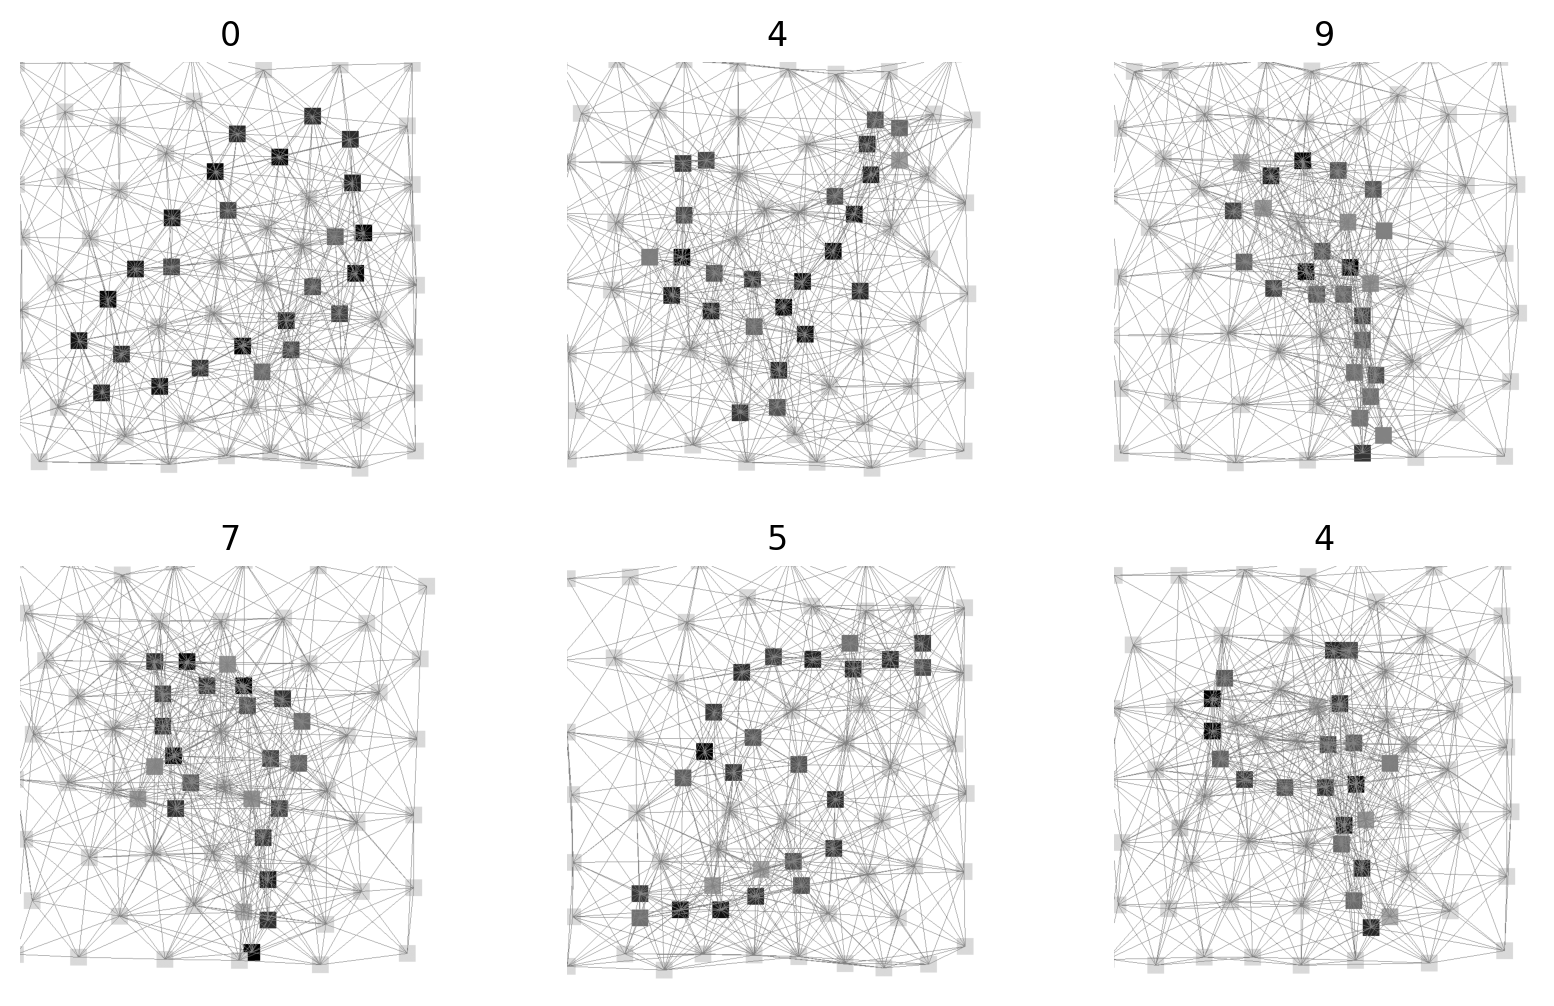

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), dpi=200)
axes = axes.flatten()
data_loader_iter = iter(data_loader)
batch = next(data_loader_iter)
for i in range(len(axes)):
    image = superpixels_to_2d_image(batch[i])
    axes[i].imshow(image, cmap=plt.cm.binary)
    axes[i].axis("off")
    axes[i].set_title(f"{batch[i].y.item()}")
plt.show()

In [4]:
batch = next(data_loader_iter)
for g in batch[:]:
    adj = to_dense_adj((g.edge_index))
    assert torch.equal(g.edge_index, (dense_to_sparse(adj)[0]))
print(batch[0])
print(batch[0].edge_attr)
print(batch)

Data(x=[75, 1], edge_index=[2, 1347], y=[1], pos=[75, 2], edge_attr=[1347, 2])
tensor([[0.2898, 0.9841],
        [0.6467, 0.9690],
        [0.9277, 0.7375],
        ...,
        [0.8388, 0.7916],
        [0.9900, 0.1806],
        [0.9366, 0.8768]])
DataBatch(x=[2400, 1], edge_index=[2, 44776], y=[32], pos=[2400, 2], edge_attr=[44776, 2], batch=[2400], ptr=[33])


In [5]:
batch.edge_attr = None
print(batch[0].edge_attr)
print(batch)
transform = T.Compose([T.Polar(cat=False)])
data = transform(batch[0])
print(data)
print(data.edge_attr)

None
DataBatch(x=[2400, 1], edge_index=[2, 44776], y=[32], pos=[2400, 2], batch=[2400], ptr=[33])
Data(x=[75, 1], edge_index=[2, 1347], y=[1], pos=[75, 2], edge_attr=[1347, 2])
tensor([[0.2898, 0.9841],
        [0.6467, 0.9690],
        [0.9277, 0.7375],
        ...,
        [0.8388, 0.7916],
        [0.9900, 0.1806],
        [0.9366, 0.8768]])


In [6]:
def generate_random_graph(n_nodes: int = 75, n_edge_feature: int = 2) -> Data:
    x: torch.Tensor = torch.rand((n_nodes, 1))
    edge_index: torch.Tensor = dense_to_sparse(torch.randint(0, 2, (n_nodes, n_nodes), dtype=torch.int64))[0]
    pos: torch.Tensor = torch.rand((n_nodes, 2)) * 28
    edge_attr: torch.Tensor = torch.rand((edge_index.shape[1], n_edge_feature))
    return Data(x=x, edge_index=edge_index, pos=pos, edge_attr=edge_attr, y=torch.Tensor(1))

# Generate graphs and concatenate batches

A random graph can be generated with the following function

Note that in this case the graph will be created on CPU.

In [7]:
def concat_batches(batches: list[Batch]) -> Batch:
    return Batch.from_data_list(
        list(itertools.chain(*[batch.to_data_list() for batch in batches]))
    )


test_batch: Batch = Batch.from_data_list(
    [
        generate_random_graph(),
        generate_random_graph(),
        generate_random_graph(),
    ]
)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Accelerator: {device}")
test_batch.to(device)
print(f"Batch is on: {test_batch.x.device}")

concatenated: Batch = concat_batches([test_batch]*4)
assert (test_batch.ptr.shape[0] - 1) * 4 == concatenated.ptr.shape[0] - 1

print(concatenated)
print(f"Concatenated batch is on: {concatenated.x.device}")

Accelerator: cuda:0
Batch is on: cuda:0
DataBatch(x=[900, 1], edge_index=[2, 33680], edge_attr=[33680, 2], y=[12], pos=[900, 2], batch=[900], ptr=[13])
Concatenated batch is on: cuda:0


# Simulation of concatenating a buffer

In [8]:
buffer: Batch = Batch.from_data_list(
    [generate_random_graph() for _ in range(10)]
)
print(buffer)
samples = Batch.from_data_list(random.choices(buffer, k=5))
print(samples)
print(concat_batches([buffer, samples]))

DataBatch(x=[750, 1], edge_index=[2, 28155], edge_attr=[28155, 2], y=[10], pos=[750, 2], batch=[750], ptr=[11])
DataBatch(x=[375, 1], edge_index=[2, 13980], edge_attr=[13980, 2], y=[5], pos=[375, 2], batch=[375], ptr=[6])
DataBatch(x=[1125, 1], edge_index=[2, 42135], edge_attr=[42135, 2], y=[15], pos=[1125, 2], batch=[1125], ptr=[16])


# Chunking example

In [9]:
sample_size: int = 20
mcmc_starting_tensors: Batch = Batch.from_data_list(
    [generate_random_graph() for _ in range(20)])
print(type(mcmc_starting_tensors))

chunked: Data = Batch.to_data_list(mcmc_starting_tensors)
print(type(chunked[0]))
len(chunked)

<class 'abc.DataBatch'>
<class 'torch_geometric.data.data.Data'>


20

# Adding Random Noise to Adjancy matrix

In [10]:
test_add_batch: Batch = Batch.from_data_list(
    [
        generate_random_graph(),
        generate_random_graph(),
        generate_random_graph(),
    ]
)
del test_add_batch.edge_attr
print(test_add_batch)

edge_index: torch.Tensor = to_dense_adj(test_add_batch.edge_index)
print(f"Initial matrix:\n{edge_index}")
noise: torch.Tensor = torch.rand(edge_index.shape)
edge_index.data.add_(noise.data)
print(f"Matrix with noise:\n{edge_index}")

dense_to_sparse(edge_index)[0]

DataBatch(x=[225, 1], edge_index=[2, 8422], y=[3], pos=[225, 2], batch=[225], ptr=[4])
Initial matrix:
tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.]]])
Matrix with noise:
tensor([[[0.9346, 1.7178, 0.7917,  ..., 0.1432, 0.3482, 0.1758],
         [1.7402, 0.9345, 0.8655,  ..., 0.7276, 0.0709, 0.9353],
         [1.5067, 1.6134, 1.5667,  ..., 0.4443, 0.2042, 0.8422],
         ...,
         [0.0486, 0.1058, 0.7096,  ..., 0.5524, 1.5537, 1.1920],
         [0.8858, 0.9961, 0.2190,  ..., 1.4616, 0.0619, 0.1631],
         [0.0063, 0.2472, 0.0432,  ..., 1.8856, 0.5462, 1.6847]]])


tensor([[  0,   0,   0,  ..., 224, 224, 224],
        [  0,   1,   2,  ..., 222, 223, 224]])

In [11]:
dense_batch: Batch = Batch.from_data_list(
    [
        generate_random_graph(),
        generate_random_graph(),
        generate_random_graph(),
    ]
)
del dense_batch.edge_attr
print(dense_batch)
edge_index: torch.Tensor = to_dense_adj(dense_batch.edge_index)
print(edge_index)
dense_batch.edge_index = edge_index
print(dense_batch)

DataBatch(x=[225, 1], edge_index=[2, 8381], y=[3], pos=[225, 2], batch=[225], ptr=[4])
tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 0.]]])
DataBatch(x=[225, 1], edge_index=[1, 225, 225], y=[3], pos=[225, 2], batch=[225], ptr=[4])


In [17]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class Small_gcn(torch.nn.Module):

    def __init__(self, out_dim: int = 10):
        super(Small_gcn, self).__init__()
        self.conv = GCNConv(1, out_dim)

    def forward(self, data):
        y = F.elu(self.conv(data.x, data.edge_index))
        return y

In [42]:
model = Small_gcn(out_dim=2)
model.to(device)

batch: Batch = Batch.from_data_list(
    [
        random_graph(device=device),
        random_graph(device=device),
        random_graph(device=device)
    ]
)

print(batch)
x, mask_x = to_dense_batch(batch.x, max_num_nodes=75, batch_size=3)
print(x.shape)
adj = to_dense_adj(batch.edge_index, max_num_nodes=75, batch_size=3)
print(adj.shape)

dense_to_sparse(adj=adj, mask=mask_x)

DataBatch(x=[225, 1], edge_index=[2, 16875], edge_attr=[16875, 2], pos=[225, 2], batch=[225], ptr=[4])
torch.Size([3, 75, 1])
torch.Size([3, 75, 75])


(tensor([[ 0,  0,  0,  ..., 74, 74, 74],
         [ 0,  1,  2,  ..., 72, 73, 74]], device='cuda:0'),
 tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0'))

In [39]:
batch.requires_grad = True
batch.x.retain_grad()

labels = torch.randint(low=0, high=2, device=device, size=(1, 3))
print(f"Labels: {labels}")
for i in range(2):
    energy: torch.Tensor = -(model(batch)[torch.arange(labels.size(0)), labels])
    print(f"Energy: {energy.shape}\n{energy}\nSum: {energy.sum()}")
    energy.sum().backward()
    print(f"Shape of grad_x: {batch.x.grad.shape}")
    print(batch.x[0])
    print(batch.x.grad[0])
    batch.x.data.add_(batch.x.grad)
    print(batch.x[0])
    batch.x.grad.zero_()
    print(batch.x.grad[0])

Labels: tensor([[1, 1, 0]], device='cuda:0')
Energy: torch.Size([1, 3])
tensor([[0.9327, 0.9327, 0.9020]], device='cuda:0', grad_fn=<NegBackward0>)
Sum: 2.767371416091919
Shape of grad_x: torch.Size([225, 1])
tensor([2.2783], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.0031], device='cuda:0')
tensor([2.2815], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.], device='cuda:0')
Energy: torch.Size([1, 3])
tensor([[0.9329, 0.9329, 0.9023]], device='cuda:0', grad_fn=<NegBackward0>)
Sum: 2.768101692199707
Shape of grad_x: torch.Size([225, 1])
tensor([2.2815], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.0031], device='cuda:0')
tensor([2.2846], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.], device='cuda:0')
